#### CSC 180 Intelligent Systems

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento


<a name='section0'></a>
# Lab 6:  Keras Tuner:  Automatic Hyperparameter Tuning for Neural Networks

 For this lab, we will use **Google Colab GPU to speed up training**.  

 ***Keras Tuner*** is one of the most popular library developed for tuning the hyperparameters of TensorFlow/Keras neural networks.

The Keras Tuner allows to define the search space for the hyperparameters over which the model will be fit, and it returns an optimal set of hyperparameters.

Keras Tuner is not part of the `Keras` package and it needs to be installed and imported.

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras_tuner as kt

### Load MNIST Dataset

To demonstrate the use of the Keras Tuner we will work with the MNIST dataset.

## MNIST Fashion Data Set

The [MNIST Fashion Data Set](https://www.tensorflow.org/datasets/catalog/fashion_mnist) is very popular in the neural network research community.  A sample of it can be seen here:

![MNIST Data Set](https://www.researchgate.net/publication/373046669/figure/fig1/AS:11431281180809965@1691723436709/The-FashionMNIST-dataset-consists-of-10-classes-of-monochrome-clothing-items-and-is.png)



In [ ]:
(img_train, label_train), (img_test, label_test) = tf.keras.datasets.fashion_mnist.load_data()


img_train = img_train.reshape(img_train.shape[0], 28, 28, 1)
img_test = img_test.reshape(img_test.shape[0], 28, 28, 1)


# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Image (#0): Which is digit '9'


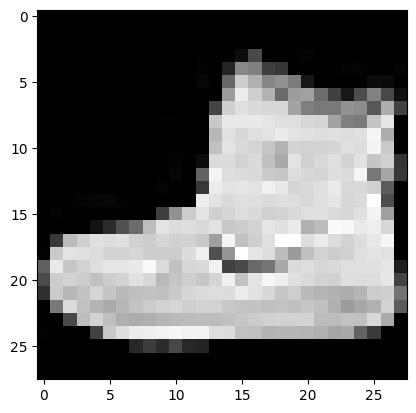

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

sample = 0    #  change this number to select another sample
img = img_train[sample]
#print(type(digit))
#print(digit.shape)


plt.imshow(img, cmap='gray')
print("Image (#{}): Which is digit '{}'".format(sample, label_train[sample]))

In [ ]:
label_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
num_classes = 10

# Converts a class vector (integers) using One-hot encoding!  Use with categorical_crossentropy.
label_train = tf.keras.utils.to_categorical(label_train, num_classes)
label_test = tf.keras.utils.to_categorical(label_test, num_classes)

### Model Builder

In the cell below, a function called `model_builder` is created, which performs search over two hyperparameters:

- Number of neurons in the first Dense layer,
- Learning rate.

The line `hp_units = hp.Int('units', min_value=32, max_value=512, step=32)` defines a grid search for the number of neurons in the Dense layer in the range [32, 64, 96, ..., 512].

Next, a grid search for the learning rate is defined in the range `[1e-2, 1e-3, 1e-4]`.

In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(28, 28, 1)))

  model.add(tf.keras.layers.Flatten())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model

### Hyperparameter Tuning

The Keras Tuner has four tuning algorithms available:

- RandomSearch Tuner, similar to the Random Grid in scikit-learn performs a random search over a distribution of values for the hyperparameters.
- Hyperband Tuner, trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round, to converge to a high-performing model.
- BayesianOptimization Tuner, performs BayesianOptimization by creating a probabilistic mapping of the model to the loss function, and iteratively evaluating promising sets of hyperparameters.
- Sklearn Tuner, designed for use with scikit-learn models.


In [ ]:
#tuner = kt.Hyperband(model_builder,
                 #    objective='val_accuracy',
                 #    max_epochs=10,
                 #    factor=3)

#max_trials represents the number of hyperparameter combinations that will be tested by the tuner,
#while execution_per_trial is the number of models that should be built and fit for each trial for robustness purposes.

tuner = kt.BayesianOptimization(
    model_builder,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="mnist_kt_test",
    overwrite=True,
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


For the sake of class time, let's only do tuning on the first 100 training/test records.  ***Please modify and run the following code on the ENTIRE dataset yourself, which may take about 1 min for each trial for the ENTIRE dataset.***


In [ ]:
tuner.search(img_train[0:100], label_train[0:100], epochs=2, validation_data=(img_test[0:100], label_test[0:100]), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Trial 10 Complete [00h 00m 05s]
val_accuracy: 0.3100000023841858

Best val_accuracy So Far: 0.6100000143051147
Total elapsed time: 00h 01m 36s


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]          # num_trials: Optional number of HyperParameters objects to return.

print(f"Optimal number of neuron in the Dense layer: {best_hps.get('units')}")
print (f"Optimal learning rate: {best_hps.get('learning_rate')}")

Optimal number of neuron in the Dense layer: 512
Optimal learning rate: 0.001


Check this link for API details:  https://keras.io/api/keras_tuner/tuners/base_tuner/

### Train and Evaluate the Model

Next, we will use the optimal hyperparameters from the Keras Tuner to create a model, and afterward we will evaluate the accuracy on the test dataset.

***Please modify and run the following code on the ENTIRE dataset yourself***


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 2 epochs
model = tuner.hypermodel.build(best_hps)
model.fit(img_train[0:100], label_train[0:100], epochs=20, validation_data=(img_test[0:100], label_test[0:100]), verbose=2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/20
4/4 - 5s - 1s/step - accuracy: 0.1800 - loss: 2.5098 - val_accuracy: 0.4100 - val_loss: 2.6888
Epoch 2/20
4/4 - 2s - 603ms/step - accuracy: 0.5800 - loss: 1.8325 - val_accuracy: 0.6200 - val_loss: 1.4105
Epoch 3/20
4/4 - 0s - 33ms/step - accuracy: 0.7900 - loss: 0.6394 - val_accuracy: 0.6200 - val_loss: 1.2003
Epoch 4/20
4/4 - 0s - 22ms/step - accuracy: 0.8500 - loss: 0.5382 - val_accuracy: 0.6900 - val_loss: 0.9935
Epoch 5/20
4/4 - 0s - 36ms/step - accuracy: 0.9200 - loss: 0.2672 - val_accuracy: 0.7000 - val_loss: 1.0001
Epoch 6/20
4/4 - 0s - 20ms/step - accuracy: 0.9700 - loss: 0.1813 - val_accuracy: 0.6700 - val_loss: 0.9832
Epoch 7/20
4/4 - 0s - 36ms/step - accuracy: 0.9900 - loss: 0.1203 - val_accuracy: 0.6300 - val_loss: 1.0281
Epoch 8/20
4/4 - 0s - 34ms/step - accuracy: 0.9900 - loss: 0.0777 - val_accuracy: 0.6800 - val_loss: 1.1102
Epoch 9/20
4/4 - 0s - 31ms/step - accuracy: 0.9900 - loss: 0.0481 - val_accuracy: 0.6600 - val_loss: 1.1652
Epoch 10/20
4/4 - 0s - 35ms/s

In [ ]:
eval_result = model.evaluate(img_test[0:100], label_test[0:100])
print("[val loss, val accuracy]:", eval_result)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6793 - loss: 1.1665 
[val loss, val accuracy]: [1.1892025470733643, 0.6800000071525574]
